In [236]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable
  Using cached pip-22.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\ProgramData\Anaconda3\python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import mean
from numpy import std
import nltk
import copy
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
from wordcloud import WordCloud
from itertools import chain
import string
import keras
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tqdm import tqdm
from keras.models import Sequential
from keras.initializers import Constant
from keras.optimizers import Adam, Adamax

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import BinaryCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout, Bidirectional, Dense
from tensorflow.keras import Model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from spellchecker import SpellChecker
import gensim
from tensorflow.random import set_seed

(7613, 4)


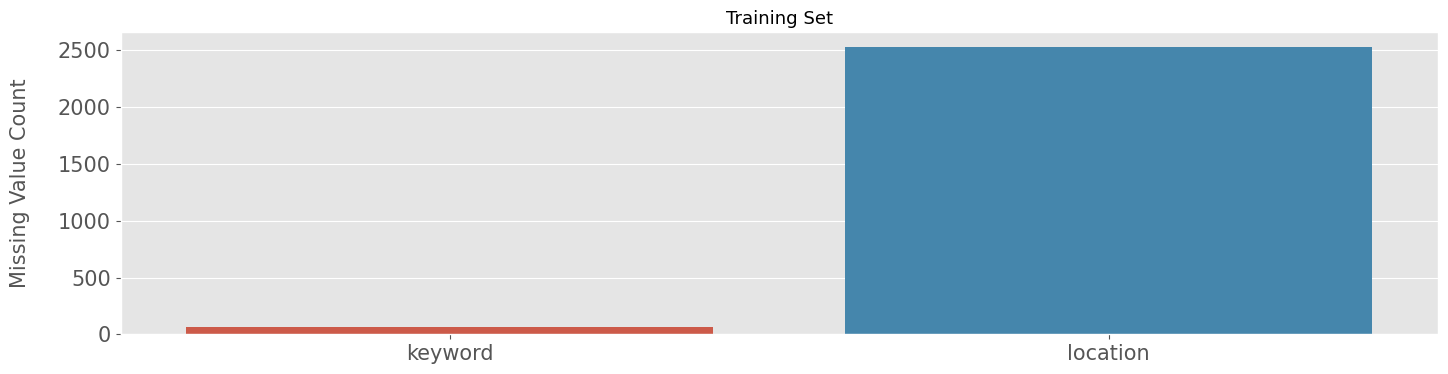

In [3]:
tweet=pd.read_csv(r"C:\Users\sasan\OneDrive\Desktop\Fall 2022 Folder\ALDA\Project\train.csv")
tweet = tweet.drop(columns=['id'])
print(tweet.shape)

#visualize missing data

missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=1, figsize=(17, 4), dpi=100)

sns.barplot(x=tweet[missing_cols].isnull().sum().index, y=tweet[missing_cols].isnull().sum().values, ax=axes)

axes.set_ylabel('Missing Value Count', size=15, labelpad=20)
axes.tick_params(axis='x', labelsize=15)
axes.tick_params(axis='y', labelsize=15)

axes.set_title('Training Set', fontsize=13)

plt.show()


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

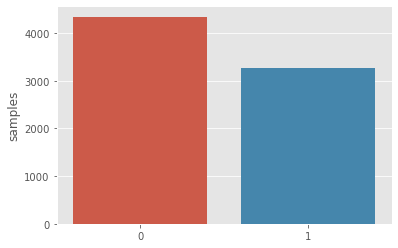

In [4]:
# from the chart - it makes sense to drop location as it is missing in more than 33% of data
# Locations are not automatically generated, they are user inputs. That's why location is very dirty and there are too many unique values in it. It shouldn't be used as a feature.
tweet = tweet.drop(columns=['location'])

#keyword can be dropped as it is already part of the tweet
tweet = tweet.drop(columns=['keyword'])

#count of classes - There is a class distribution.There are more tweets with class 0 ( No disaster) than class 1 ( disaster tweets)

x=tweet.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

In [5]:
def create_corpus(target):
    corpus = []

    for x in tweet[tweet['target'] == target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus = create_corpus(0)
corpus.extend(create_corpus(1))

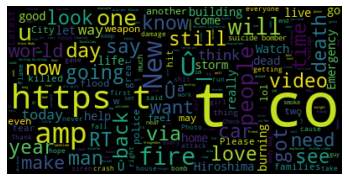

In [6]:
corpus_merged=create_corpus(1)
corpus_merged.extend(create_corpus(0))
wc = WordCloud(background_color='black')
wc.generate(' '.join(corpus_merged))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

<AxesSubplot:>

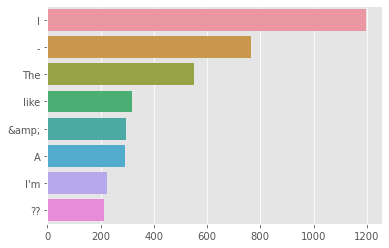

In [7]:
#common words
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [8]:
abbreviations = {
    "$" : " dollar ",  "€" : " euro ",  "4ao" : "for adults only",  "a.m" : "before midday",  "a3" : "anytime anywhere anyplace",  "aamof" : "as a matter of fact",  "acct" : "account",  "adih" : "another day in hell",  "afaic" : "as far as i am concerned",  "afaict" : "as far as i can tell",  "afaik" : "as far as i know",  "afair" : "as far as i remember",  "afk" : "away from keyboard",  "app" : "application",  "approx" : "approximately",  "apps" : "applications",  "asap" : "as soon as possible",  "asl" : "age, sex, location",  "atk" : "at the keyboard",  "ave." : "avenue",  "aymm" : "are you my mother",  "ayor" : "at your own risk",   
    "b&b" : "bed and breakfast",  "b+b" : "bed and breakfast",  "b.c" : "before christ",  "b2b" : "business to business",  "b2c" : "business to customer",  "b4" : "before",  "b4n" : "bye for now",  "b@u" : "back at you",  "bae" : "before anyone else",  "bak" : "back at keyboard",  "bbbg" : "bye bye be good",  "bbc" : "british broadcasting corporation",  "bbias" : "be back in a second",  "bbl" : "be back later",  "bbs" : "be back soon",  "be4" : "before",  "bfn" : "bye for now",  "blvd" : "boulevard",  "bout" : "about",  "brb" : "be right back",  "bros" : "brothers",  "brt" : "be right there",  "bsaaw" : "big smile and a wink",  "btw" : "by the way",  "bwl" : "bursting with laughter", 
    "c/o" : "care of",  "cet" : "central european time",  "cf" : "compare",  "cia" : "central intelligence agency",  "csl" : "can not stop laughing",  "cu" : "see you",  "cul8r" : "see you later",  "cv" : "curriculum vitae",  "cwot" : "complete waste of time",  "cya" : "see you",  "cyt" : "see you tomorrow",  "dae" : "does anyone else",  "dbmib" : "do not bother me i am busy",  "diy" : "do it yourself",  "dm" : "direct message",  "dwh" : "during work hours",  "e123" : "easy as one two three",  "eet" : "eastern european time",  "eg" : "example",  "embm" : "early morning business meeting",  "encl" : "enclosed",  "encl." : "enclosed",  "etc" : "and so on",  "faq" : "frequently asked questions",  
    "fawc" : "for anyone who cares",  "fb" : "facebook",  "fc" : "fingers crossed",  "fig" : "figure",  "fimh" : "forever in my heart",   "ft." : "feet",  "ft" : "featuring",  "ftl" : "for the loss",  "ftw" : "for the win",  "fwiw" : "for what it is worth",  "fyi" : "for your information",  "g9" : "genius",  "gahoy" : "get a hold of yourself",  "gal" : "get a life",  "gcse" : "general certificate of secondary education",  "gfn" : "gone for now",  "gg" : "good game",  "gl" : "good luck",  "glhf" : "good luck have fun",  "gmt" : "greenwich mean time",  "gmta" : "great minds think alike",  "gn" : "good night",  "g.o.a.t" : "greatest of all time",  "goat" : "greatest of all time",  "goi" : "get over it",  
    "gps" : "global positioning system",  "gr8" : "great",  "gratz" : "congratulations",  "gyal" : "girl",  "h&c" : "hot and cold",  "hp" : "horsepower",  "hr" : "hour",  "hrh" : "his royal highness",  "ht" : "height",  "ibrb" : "i will be right back",  "ic" : "i see",  "icq" : "i seek you",  "icymi" : "in case you missed it",  "idc" : "i do not care",  "idgadf" : "i do not give a damn fuck",  "idgaf" : "i do not give a fuck",  "idk" : "i do not know",  "ie" : "that is",  "i.e" : "that is",  "ifyp" : "i feel your pain",  "IG" : "instagram",  "iirc" : "if i remember correctly",  "ilu" : "i love you",  "ily" : "i love you",  "imho" : "in my humble opinion",  "imo" : "in my opinion", 
    "imu" : "i miss you",  "iow" : "in other words",  "irl" : "in real life",  "j4f" : "just for fun",  "jic" : "just in case",  "jk" : "just kidding",  "jsyk" : "just so you know",  "l8r" : "later",  "lb" : "pound",  "lbs" : "pounds",  "ldr" : "long distance relationship",  "lmao" : "laugh my ass off",  "lmfao" : "laugh my fucking ass off",  "lol" : "laughing out loud",  "ltd" : "limited",  "ltns" : "long time no see",  "m8" : "mate",  "mf" : "motherfucker",  "mfs" : "motherfuckers",  "mfw" : "my face when",  "mofo" : "motherfucker",  "mph" : "miles per hour",  "mr" : "mister",  "mrw" : "my reaction when",  "ms" : "miss",  "mte" : "my thoughts exactly",  "nagi" : "not a good idea",  
    "nbc" : "national broadcasting company",  "nbd" : "not big deal",  "nfs" : "not for sale",  "ngl" : "not going to lie",  "nhs" : "national health service",  "nrn" : "no reply necessary",  "nsfl" : "not safe for life",  "nsfw" : "not safe for work",  "nth" : "nice to have",  "nvr" : "never",  "nyc" : "new york city",  "oc" : "original content",  "og" : "original",  "ohp" : "overhead projector",  "oic" : "oh i see",  "omdb" : "over my dead body",  "omg" : "oh my god",  "omw" : "on my way",  "p.a" : "per annum",  "p.m" : "after midday",  "pm" : "prime minister",  "poc" : "people of color",  "pov" : "point of view",  "pp" : "pages",  "ppl" : "people",  "prw" : "parents are watching",  
    "ps" : "postscript",  "pt" : "point",  "ptb" : "please text back",  "pto" : "please turn over",  "qpsa" : "what happens",  "ratchet" : "rude",  "rbtl" : "read between the lines",  "rlrt" : "real life retweet",   "rofl" : "rolling on the floor laughing",  "roflol" : "rolling on the floor laughing out loud",  "rotflmao" : "rolling on the floor laughing my ass off",  "rt" : "retweet",  "ruok" : "are you ok",  "sfw" : "safe for work",  "sk8" : "skate",  "smh" : "shake my head",  "sq" : "square",  "srsly" : "seriously",   "ssdd" : "same stuff different day",  "tbh" : "to be honest",  "tbs" : "tablespooful",  "tbsp" : "tablespooful",  "tfw" : "that feeling when",  "thks" : "thank you",  
    "tho" : "though",  "thx" : "thank you",  "tia" : "thanks in advance",  "til" : "today i learned",  "tl;dr" : "too long i did not read",  "tldr" : "too long i did not read",  "tmb" : "tweet me back",  "tntl" : "trying not to laugh",  "ttyl" : "talk to you later",  "u" : "you",  "u2" : "you too",  "u4e" : "yours for ever",  "utc" : "coordinated universal time",  "w/" : "with",  "w/o" : "without",  "w8" : "wait",  "wassup" : "what is up",  "wb" : "welcome back",  "wtf" : "what the fuck",  "wtg" : "way to go",  "wtpa" : "where the party at",  "wuf" : "where are you from",  "wuzup" : "what is up",  "wywh" : "wish you were here",  "yd" : "yard",  "ygtr" : "you got that right",  
    "ynk" : "you never know",  "zzz" : "sleeping bored and tired"
}

# Change an abbreviation by its true meaning
def word_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word

# Replace all abbreviations
def replace_abbrev(text):
    string = ""
    for word in text.split():
        string += word_abbrev(word) + " "        
    return string

In [9]:

#since most of the common words are stop words - a lot of cleaning is required

def clean_tweet(text):
    # converting text to lower case
    text = text.lower()
    # removing all mentions and hashtags from the tweet
    temp = re.sub("@[a-z0-9_]+", "", text)
    temp = re.sub("#[a-z0-9_]+", "", temp)
    # removing all websites and urls from the tweet
    temp = re.sub(r"http\S+", "", temp)
    temp = re.sub(r"www.\S+", "", temp)
    # removing punctuations from the tweet
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]', ' ', temp)
    # removing all non-alphanumeric characters from the text
    temp = re.sub("[^a-z0-9]", " ", temp)
    
    #expand abbrevations
    text = replace_abbrev(text)
    # correcting spellings
    # temp = correct_spellings(temp)

    # removing all stopwords from the text -- #todo check accuracy with and without removing these
    temp = temp.split()
    temp = [w for w in temp if not w in stop]
    temp = " ".join(word for word in temp)

    # not stemming because the stemmed words will not be present in Glove and word2vec databases

    return temp



In [10]:
rawTexData = tweet["text"].head(10)

tweet['text']=tweet['text'].apply(lambda x : clean_tweet(x))
cleanTexData = tweet["text"].head(10)

In [11]:
#visualization of tf-idf and word2vec
X_train, X_test, y_train, y_test = train_test_split(tweet["text"], tweet["target"], test_size=0.2, random_state=2022)


In [12]:
#plotting using latent sentiment analysis - This transformer performs linear dimensionality reduction by means of truncated singular value decomposition
def plot_LSA(test_data, test_labels, plot=True):
    lsa = TruncatedSVD(n_components=2)
    lsa.fit(test_data)
    lsa_scores = lsa.transform(test_data)
    color_mapper = {label: idx for idx, label in enumerate(set(test_labels))}
    color_column = [color_mapper[label] for label in test_labels]
    colors = ['red', 'blue', 'green']
    if plot:
        plt.scatter(lsa_scores[:, 0], lsa_scores[:, 1], s=8, alpha=.8, c=test_labels,
                    cmap=matplotlib.colors.ListedColormap(colors))
        red_patch = mpatches.Patch(color='red', label='Not Disaster')
        green_patch = mpatches.Patch(color='green', label='Disaster')
        plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

#plotting tfidf
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


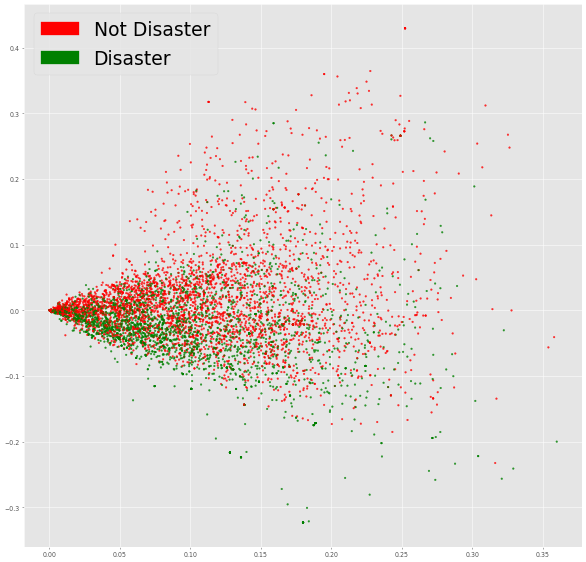

In [13]:
X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

fig = plt.figure(figsize=(16, 16),dpi=45)
plot_LSA(X_train_tfidf, y_train)
plt.show()

In [14]:
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [15]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged


def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [16]:
tokenizer = RegexpTokenizer(r'\w+')
list_labels = tweet["target"].tolist()
tweet["tokens"] = tweet["text"].apply(tokenizer.tokenize)
tweet.head()


,text,target,tokens
0,our deeds are the reason of this may allah fo...,1,"[our, deeds, are, the, reason, of, this, may, ..."
1,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]"
2,all residents asked to shelter in place are ...,1,"[all, residents, asked, to, shelter, in, place..."
3,13 000 people receive evacuation orders in ca...,1,"[13, 000, people, receive, evacuation, orders,..."
4,just got sent this photo from ruby as smoke f...,1,"[just, got, sent, this, photo, from, ruby, as,..."


In [17]:
max_features=3000
tokenizer=Tokenizer(num_words=max_features,split=' ')
tokenizer.fit_on_texts(tweet['tokens'].values)
X = tokenizer.texts_to_sequences(tweet['tokens'].values)
X = pad_sequences(X)
X_train_word2vec1, X_test_word2vec1, y_train_word2vec1, y_test_word2vec1 = train_test_split(X, list_labels, test_size=0.2, random_state=2022)

In [18]:
embeddings = get_word2vec_embeddings(word2vec, tweet)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, test_size=0.2, random_state=2022)

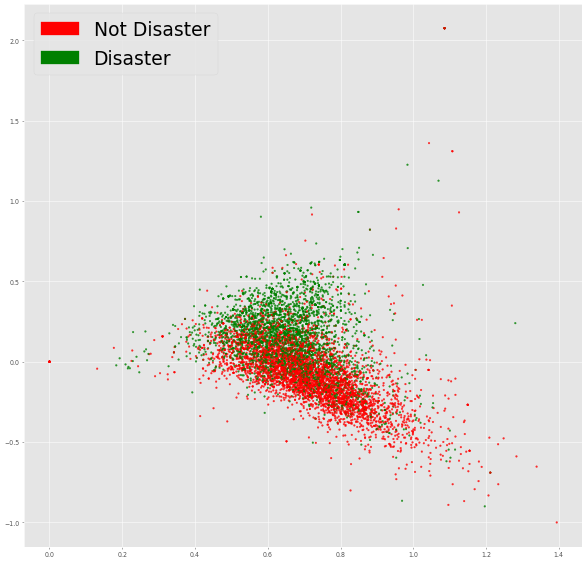

In [19]:
#plotting word2vec
fig = plt.figure(figsize=(16, 16),dpi=45)
plot_LSA(embeddings, list_labels)
plt.show()


In [20]:

#Logistic regression
logistic_reg = LogisticRegression(penalty='l2',
                                        solver='saga',
                                        random_state = 2022)

logistic_reg.fit(X_train_word2vec,y_train_word2vec)
print("Logistic Regression model run successfully")


Logistic Regression model run successfully


In [47]:

#SVM
SVClassifier = SVC(kernel= 'rbf',
                   degree=3,
                   max_iter=10000,
                   C=2,
                   random_state = 2022)

SVClassifier.fit(X_train_word2vec,y_train_word2vec)

print("SVClassifier model run successfully")


SVClassifier model run successfully


In [48]:
models = [logistic_reg, SVClassifier]
precision_sc=[]
recall_sc=[]
f1_sc=[]
test_sc=[]
train_sc=[]
for model in models:
    print(type(model).__name__,'Train Score is   : ' ,model.score(X_train_word2vec, y_train_word2vec))
    print(type(model).__name__,'Test Score is    : ' ,model.score(X_test_word2vec, y_test_word2vec))
    train_sc.append(model.score(X_train_word2vec, y_train_word2vec))
    test_sc.append(model.score(X_test_word2vec, y_test_word2vec))
    y_pred_word2vec = model.predict(X_test_word2vec)

    print(type(model).__name__,'Precision is      : ' ,precision_score(y_test_word2vec,y_pred_word2vec))   
    print(type(model).__name__,'Recall is         : ' ,recall_score(y_test_word2vec,y_pred_word2vec))  
    print(type(model).__name__,'F1 Score is       : ' ,f1_score(y_test_word2vec,y_pred_word2vec))
    precision_sc.append(precision_score(y_test_word2vec,y_pred_word2vec))
    recall_sc.append(recall_score(y_test_word2vec,y_pred_word2vec))
    f1_sc.append(f1_score(y_test_word2vec,y_pred_word2vec))
    print('**************************************************************')

    

LogisticRegression Train Score is   :  0.8098522167487685
LogisticRegression Test Score is    :  0.8135259356533159
LogisticRegression Precision is      :  0.8126036484245439
LogisticRegression Recall is         :  0.7413010590015129
LogisticRegression F1 Score is       :  0.7753164556962026
**************************************************************
SVC Train Score is   :  0.8935960591133005
SVC Test Score is    :  0.8417596848325674
SVC Precision is      :  0.8559322033898306
SVC Recall is         :  0.7639939485627837
SVC F1 Score is       :  0.8073541167066348
**************************************************************


In [23]:
train = xgb.DMatrix(X_train_word2vec, label = y_train_word2vec)
test = xgb.DMatrix(X_test_word2vec, label = y_test_word2vec)
param = {
        'max_depth': 4,
        'eta': 0.2,
        'objective': 'multi:softmax',
        'num_class':2}
#epochs = [10, 20, 50, 100, 500]
#train_scores = []
#test_scores = []

epochs = 50

xgmodel = xgb.train(param, train, epochs)

predictions = xgmodel.predict(train)
xgb_acc_train = accuracy_score(y_train_word2vec,predictions)

print('XGboost Train Score is: ', xgb_acc_train)
train_sc.append(float(xgb_acc_train))

predictions = xgmodel.predict(test)
xgb_acc_test = accuracy_score(y_test_word2vec,predictions)

print('XGboost Test Score is: ', xgb_acc_test)
test_sc.append(float(xgb_acc_test))

a= precision_score(y_test_word2vec,predictions)
b=recall_score(y_test_word2vec,predictions)
c=f1_score(y_test_word2vec,predictions)
print('XGboost Precision is      : ', a)   
print('XGboost Recall is         : ' ,b)  
print('XGboost F1 Score is       : ' ,c)

precision_sc.append(precision_score(y_test_word2vec,predictions))
recall_sc.append(recall_score(y_test_word2vec,predictions))
f1_sc.append(f1_score(y_test_word2vec,predictions))

XGboost Train Score is:  0.9113300492610837
XGboost Test Score is:  0.8220617202889035
XGboost Precision is      :  0.8186274509803921
XGboost Recall is         :  0.7579425113464447
XGboost F1 Score is       :  0.7871170463472112


In [24]:
#print('train scores',train_scores)
#print('test scores',test_scores)

fig = plt.figure(1)
plt.plot(epochs, train_scores,label="Train Scores XGBoost") # plot first line
plt.plot(epochs,test_scores,label="Test Scores XGBoost") # plot second line
plt.legend(["Train Scores XGBoost", "Test Scores XGBoost"], loc ="lower right")
plt.xlabel("# Epochs")
plt.ylabel("Score")

plt.show()

NameError: name 'train_scores' is not defined

<Figure size 432x288 with 0 Axes>

[(0.8098522167487685, 0.8135259356533159, 0.8126036484245439, 0.7413010590015129, 0.7753164556962026), (0.8935960591133005, 0.8417596848325674, 0.8559322033898306, 0.7639939485627837, 0.8073541167066348), (0.8312, 0.85884, 0.8377, 0.7579, 0.7958)]


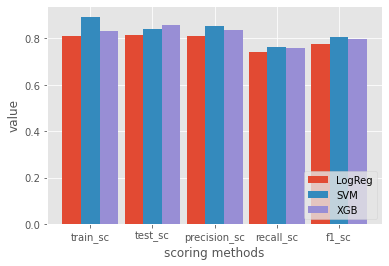

In [39]:
X = ['train_sc','test_sc','precision_sc','recall_sc', 'f1_sc'] 
scores = list(zip(train_sc,test_sc,precision_sc,recall_sc,f1_sc))
print(scores)
names = ['LogReg', 'SVM' , 'XGB']
X_axis = np.arange(len(X)) 
plt.bar(X_axis - 0.3, scores[0], 0.3, label = 'LogReg') 
plt.bar(X_axis, scores[1], 0.3, label = 'SVM') 
plt.bar(X_axis + 0.3, scores[2], 0.3, label = 'XGB')   
plt.xticks(X_axis, X) 
plt.xlabel("scoring methods") 
plt.ylabel("value") 
plt.legend( loc ="lower right") 
plt.show() 
 

In [24]:
cv = KFold(n_splits=6, random_state=1, shuffle=True)
xgb_acc=''
lstm_acc=''
for model in models:
    scores = cross_val_score(model, embeddings, list_labels, scoring='accuracy', cv=cv, n_jobs=-1)
    # report performance
    print(type(model).__name__,' 6-fold cross validation accuracy: %.3f ' % (mean(scores)))
print('XGBoost 6-fold cross validation accuracy: 0.818 ',xgb_acc)
print('LSTM 6-fold cross validation accuracy: 0.75',lstm_acc)

LogisticRegression  6-fold cross validation accuracy: 0.796 
SVC  6-fold cross validation accuracy: 0.796 
XGBoost 6-fold cross validation accuracy: 0.818  
LSTM 6-fold cross validation accuracy: 0.75 


In [31]:
embed_dim = 32
lstm_out = 32
model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = 31))
model.add(Dropout(0.2))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
adam = Adam(learning_rate=0.002)
model.compile(loss = 'binary_crossentropy', optimizer=adam ,metrics = ['accuracy'])
print(model.summary())

#model.fit(np.array(X_train_word2vec), np.array(y_train_word2vec), epochs = 10, batch_size=32, validation_data=(np.array(X_test_word2vec), np.array(y_test_word2vec)))
model.fit(np.array(X_train_word2vec1), np.array(y_train_word2vec1), epochs = 10, batch_size=32, validation_data=(np.array(X_test_word2vec1), np.array(y_test_word2vec1)))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 31, 32)            96000     
                                                                 
 dropout_4 (Dropout)         (None, 31, 32)            0         
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 104,353
Trainable params: 104,353
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
191/191 [==============================] - 5s 16ms/step - loss: 0.5567 - accuracy: 0.7140 - val_loss: 0.4276 - val_accuracy: 0.8076
Epoch 2/10
191/191 [============

In [27]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.15, 0.2],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.5],   
}

# Init classifier
xgb_cl = xgb.XGBClassifier(objective= "multi:softmax", num_class = 2)

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=6, scoring="roc_auc")

# Fit
grid_cv.fit(X_train_word2vec, y_train_word2vec)

grid_cv.best_score_

model = xgb.XGBClassifier(
    **grid_cv.best_params_,
    objective="multi:softmax",
    num_class = 2
)

model.fit(X_train_word2vec, y_train_word2vec)

predictions = model.predict(X_test_word2vec)

a= precision_score(y_test_word2vec,predictions)
b=recall_score(y_test_word2vec,predictions)
c=f1_score(y_test_word2vec,predictions)
d=accuracy_score(y_test_word2vec,predictions)
e=grid_cv.best_score_

print('XGboost Train Score is: ',e)
train_sc.append(float(e))

print('XGboost Test Score is: ',d )
test_sc.append(float(d))

print('XGboost Precision is      : ', a)   
print('XGboost Recall is         : ' ,b)  
print('XGboost F1 Score is       : ' ,c)

precision_sc.append(a)
recall_sc.append(b)
f1_sc.append(c)

XGboost Train Score is:  0.8588459505879243
XGboost Test Score is:  0.8312541037426132
XGboost Precision is      :  0.8377926421404682
XGboost Recall is         :  0.7579425113464447
XGboost F1 Score is       :  0.7958697378872122


In [36]:
param_grid = {
    "max_depth": [3, 4, 5, 7],
    "learning_rate": [0.1, 0.15, 0.2],
    "gamma": [0, 0.25, 1],
    "reg_lambda": [0, 1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.5],   
}

# Init classifier
xgb_cl = xgb.XGBClassifier(objective= "multi:softmax", num_class = 2)

# Init Grid Search
grid_cv = GridSearchCV(xgb_cl, param_grid, n_jobs=-1, cv=6, scoring="roc_auc")

# Fit
grid_cv.fit(X_train_word2vec, y_train_word2vec)


GridSearchCV(cv=6,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                   

In [28]:
model.fit(X_train_word2vec, y_train_word2vec)

predictions = model.predict(X_test_word2vec)

a= precision_score(y_test_word2vec,predictions)
b=recall_score(y_test_word2vec,predictions)
c=f1_score(y_test_word2vec,predictions)
d=accuracy_score(y_test_word2vec,predictions)
e=grid_cv.best_score_
print('XGboost Train Score is: ',e)
train_sc.append(float(e))

print('XGboost Test Score is: ',d )
test_sc.append(float(d))

print('XGboost Precision is      : ', a)   
print('XGboost Recall is         : ' ,b)  
print('XGboost F1 Score is       : ' ,c)

precision_sc.append(a)
recall_sc.append(b)
f1_sc.append(c)

XGboost Train Score is:  0.8588459505879243
XGboost Test Score is:  0.8312541037426132
XGboost Precision is      :  0.8377926421404682
XGboost Recall is         :  0.7579425113464447
XGboost F1 Score is       :  0.7958697378872122


In [38]:
test_sc.append(0.85884)
train_sc.append(0.8312)
precision_sc.append(0.8377)
recall_sc.append(0.7579)
f1_sc.append(0.7958)